# Importação das bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
from scipy import stats
import pingouin as pg

In [4]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import optuna
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import pickle

In [5]:
import warnings
warnings.filterwarnings('ignore', message="use_inf_as_na option is deprecated", category=FutureWarning) # Ignorar temporarimente um aviso

# Importação do banco de dados

In [6]:
db_imdb = pd.read_csv("../Dataset/desafio_indicium_imdb.csv") # Leitura do arquivo csv
db_imdb.head()

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


# Análise Exploratória

**Atributos**

- *Series_Title:* Nome do filme
- *Released_Year:*  Ano de lançament
- *Certificate:* Classificação etária
- *Runtime:* Tempo de duração
- *Genre:* Gênero
- *Overview:* Overview do filme
- *Meta_score:* Média ponderada de todas as críticas
- *Director:* Diretor
- *Star1:* Ator/atriz #1
- *Star2:* Ator/atriz #2
- *Star3:* Ator/atriz #3
- *Star4:* Ator/atriz #4
- *No_of_Votes:* Número de votos
- *Gross:* Faturamento
- *IMDB_Rating:* Nota do IMDB- Faturamento


In [7]:
db_imdb.info() # Informações sobre os atributos do dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


In [8]:
db_imdb.isnull().sum() # Soma dos valores nulos em cada atributo

Unnamed: 0         0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

In [9]:
db_imdb.duplicated().sum() # Contagem de linhas duplicadas

0

In [10]:
db_imdb.drop(columns="Unnamed: 0", inplace=True) # Eliminação da coluna dos índices

# Tratamento dos dados

## Exclusão dos valores nulos

In [11]:
db_imdb.dropna(inplace=True) # Eliminação dos valores nulos

In [12]:
db_imdb.shape # Número de linha e colunas depois da eliminação dos valores nulos

(713, 15)

## Eliminando a unidade de tempo da coluna 'Runtime'

In [13]:
db_imdb['Runtime (min)'] = db_imdb['Runtime'].str.replace(" min", "").astype("int64") # Eliminando a unidade de tempo dos valores e alterando o tipo da coluna para 'int64'
db_imdb.drop(columns="Runtime", inplace=True) # Eliminação da coluna 'Runtime' que possui valores do tipo 'object' contendo a unidade de tempo
db_imdb['Runtime (min)']

0      175
1      152
2      202
3       96
4      201
      ... 
989    157
990    144
991     78
993     87
996    118
Name: Runtime (min), Length: 713, dtype: int64

## Transformação do tipo de algumas colunas

### Coluna 'Released_Year'

In [14]:
db_imdb['Released_Year'].unique() # Verificando a presença de valores inválidos

array(['1972', '2008', '1974', '1957', '2003', '1994', '1993', '2010',
       '1999', '2001', '1966', '2002', '1990', '1980', '1975', '2019',
       '2014', '1998', '1997', '1995', '1991', '1977', '1954', '2011',
       '2006', '2000', '1988', '1985', '1968', '1960', '1942', '1936',
       '1931', '2018', '2016', '2017', '2012', '2009', '1981', '1979',
       '1964', '2004', '1992', '1987', '1986', '1984', '1983', '1976',
       '1973', '1971', '1965', '1962', '1959', '1958', '1952', '1944',
       '1941', '2013', '2007', '2005', '1989', '1963', '1950', '1948',
       '2015', '1996', '1982', '1978', '1967', '1951', '1949', '1940',
       '1939', '1934', '1970', '1969', '1961', '1946', '1930', '1938',
       '1933', 'PG', '1953'], dtype=object)

In [15]:
db_imdb = db_imdb[db_imdb['Released_Year']!='PG'] # Excluindo linhas com valor inválido para coluna 'Released_Year'
db_imdb.shape

(712, 15)

In [16]:
db_imdb['Released_Year'] = db_imdb['Released_Year'].astype('int64')

### Coluna 'Gross'

In [17]:
db_imdb.loc[:, 'Gross'] = db_imdb['Gross'].str.replace(',', '')
db_imdb['Gross']

0      134966411
1      534858444
2       57300000
3        4360000
4      377845905
         ...    
989       696690
990      1378435
991    141843612
993     13780024
996     30500000
Name: Gross, Length: 712, dtype: object

In [18]:
db_imdb['Gross'] = db_imdb['Gross'].astype('int64')

## Separando os gêneros em uma lista

In [19]:
db_imdb['Genre'] = db_imdb['Genre'].str.split(", ") # Criando uma lista para cada filme contendo seus gêneros ao invés de uma string
db_imdb['Genre']

0                      [Crime, Drama]
1              [Action, Crime, Drama]
2                      [Crime, Drama]
3                      [Crime, Drama]
4          [Action, Adventure, Drama]
                    ...              
989             [Drama, War, Western]
990          [Adventure, Comedy, War]
991    [Animation, Adventure, Family]
993          [Comedy, Music, Musical]
996             [Drama, Romance, War]
Name: Genre, Length: 712, dtype: object

## Extração de tópicos do 'Overview'

In [20]:
tfidf = TfidfVectorizer(stop_words='english', max_features=15)

In [21]:
tfidf_overview = tfidf.fit_transform(db_imdb['Overview']) # Extração das palavras mais importantes de todas as descrições dos filmes

In [175]:
df_overview = pd.DataFrame(tfidf_overview.toarray(), columns=tfidf.get_feature_names_out(), index=db_imdb.index) # Criação de um dataframe tendo como colunas as principais palavras extraídas e como linhas a importância relativa de cada palavra na descrição de seu respectivo filme
df_overview.to_excel('../resultados/PalavrasOverview.xlsx', index=False)
df_overview

,boy,family,father,help,life,love,man,new,old,son,story,war,woman,world,young
0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.504176,0.0,0.0,0.433782,0.0,0.0,0.482869,0.0,0.569629,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
990,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
991,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
993,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


# Análise Estatística

In [23]:
db_imdb # Visualização do dataset após aplicação de alguns tratamentos

,Series_Title,Released_Year,Certificate,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Runtime (min)
0,The Godfather,1972,A,"[Crime, Drama]",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411,175
1,The Dark Knight,2008,UA,"[Action, Crime, Drama]",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444,152
2,The Godfather: Part II,1974,A,"[Crime, Drama]",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000,202
3,12 Angry Men,1957,U,"[Crime, Drama]",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000,96
4,The Lord of the Rings: The Return of the King,2003,U,"[Action, Adventure, Drama]",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,Giù la testa,1971,PG,"[Drama, War, Western]",7.6,A low-life bandit and an I.R.A. explosives exp...,77.0,Sergio Leone,Rod Steiger,James Coburn,Romolo Valli,Maria Monti,30144,696690,157
990,Kelly's Heroes,1970,GP,"[Adventure, Comedy, War]",7.6,A group of U.S. soldiers sneaks across enemy l...,50.0,Brian G. Hutton,Clint Eastwood,Telly Savalas,Don Rickles,Carroll O'Connor,45338,1378435,144
991,The Jungle Book,1967,U,"[Animation, Adventure, Family]",7.6,Bagheera the Panther and Baloo the Bear have a...,65.0,Wolfgang Reitherman,Phil Harris,Sebastian Cabot,Louis Prima,Bruce Reitherman,166409,141843612,78
993,A Hard Day's Night,1964,U,"[Comedy, Music, Musical]",7.6,"Over two ""typical"" days in the life of The Bea...",96.0,Richard Lester,John Lennon,Paul McCartney,George Harrison,Ringo Starr,40351,13780024,87


## Descrição estatística das colunas quantitativas

In [206]:
quantitativas = ['Released_Year', 'IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Gross', 'Runtime (min)'] # Lista contendo as colunas do dataset que são quantitativas
descricao_est = db_imdb[quantitativas].describe() # Descrição estatística das colunas quantitativas
descricao_est.to_excel('../resultados/DescriçãoEstatística.xlsx', index=True)
descricao_est

,Released_Year,IMDB_Rating,Meta_score,No_of_Votes,Gross,Runtime (min)
count,712.000000,712.000000,712.000000,7.120000e+02,7.120000e+02,712.000000
mean,1995.738764,7.935674,77.154494,3.534662e+05,7.845017e+07,123.667135
std,18.611182,0.288928,12.418115,3.464502e+05,1.150686e+08,25.907607
min,1930.000000,7.600000,28.000000,2.522900e+04,1.305000e+03,72.000000
25%,1986.750000,7.700000,69.750000,9.566475e+04,6.143199e+06,104.000000
50%,2001.000000,7.900000,78.000000,2.359815e+05,3.485015e+07,120.000000
75%,2010.000000,8.100000,86.000000,5.065428e+05,1.023606e+08,136.000000
max,2019.000000,9.200000,100.000000,2.303232e+06,9.366622e+08,238.000000


## Frequências das colunas qualitativas

### Coluna 'Certificate'

In [207]:
freq_certificate = pd.DataFrame({'Frequência': db_imdb['Certificate'].value_counts(),
                                     'Percentual': (db_imdb['Certificate'].value_counts(normalize=True)*100).map('{:.2f}%'.format)})
freq_certificate.to_excel('../resultados/FreqCertificate.xlsx', index=True)
freq_certificate # Frequência e percentual das classificações etárias

,Frequência,Percentual
Certificate,,
U,182,25.56%
A,173,24.30%
UA,142,19.94%
R,131,18.40%
PG-13,38,5.34%
PG,19,2.67%
G,9,1.26%
Passed,9,1.26%
Approved,6,0.84%


### Coluna 'Genre'

In [208]:
df_genre_exp = db_imdb['Genre'].explode()
freq_genres = pd.DataFrame({'Frequência': df_genre_exp.value_counts(),
                            'Percentual': (df_genre_exp.explode().value_counts()*100/712).map('{:.2f}%'.format)})
freq_genres.to_excel('../resultados/FreqGenre.xlsx', index=True)
freq_genres # Exibindo a frequência dos gêneros e seu percentual em relação ao número de filmes

,Frequência,Percentual
Genre,,
Drama,498,69.94%
Adventure,162,22.75%
Comedy,161,22.61%
Crime,142,19.94%
Action,140,19.66%
Thriller,99,13.90%
Biography,88,12.36%
Romance,88,12.36%
Mystery,70,9.83%


### Coluna 'Overview'

In [209]:
words_importance = np.array(tfidf_overview.sum(axis=0)).ravel()
freq_overview_words = pd.DataFrame(index=tfidf.get_feature_names_out(), 
                                   data={'Importância Total': words_importance, 
                                    'Importância Relativa': [f'{x*100/sum(words_importance):.2f}%' for x in words_importance]})
freq_overview_words = freq_overview_words.sort_values(by='Importância Total', ascending=False)
freq_overview_words.to_excel('../resultados/FreqOverview.xlsx', index=True)
freq_overview_words # Exibindo a frequência e o percentual das principais palavras extraídas pela vetorização ordenadas de ordem crescente em relação a importância total

,Importância Total,Importância Relativa
life,59.931110,10.99%
young,55.420808,10.17%
man,53.539380,9.82%
world,44.222712,8.11%
new,41.792204,7.67%
story,38.291113,7.02%
family,35.969135,6.60%
war,31.458586,5.77%
woman,31.139281,5.71%
help,28.471910,5.22%


### Coluna 'Director'

In [210]:
freq_director = pd.DataFrame({'Frequência': db_imdb['Director'].value_counts(),
                                'Percentual': (db_imdb['Director'].value_counts(normalize=True)*100).map('{:.2f}%'.format)})
freq_director.to_excel('../resultados/FreqDirector.xlsx', index=True)
freq_director.iloc[:10] # Exibindo a frequência e o percentual dos 10 diretores principais

,Frequência,Percentual
Director,,
Steven Spielberg,13,1.83%
Martin Scorsese,10,1.40%
Alfred Hitchcock,9,1.26%
David Fincher,8,1.12%
Clint Eastwood,8,1.12%
Quentin Tarantino,8,1.12%
Christopher Nolan,8,1.12%
Woody Allen,7,0.98%
Rob Reiner,7,0.98%


### Colunas 'Star1', 'Star2', 'Star3'e 'Star4'

In [29]:
df_stars = pd.concat([db_imdb['Star1'], db_imdb['Star2'], db_imdb['Star3'], db_imdb['Star4']], axis=0).reset_index(drop=True) # Unindo os atores e atrizes em um único dataframe
df_stars

0          Marlon Brando
1         Christian Bale
2              Al Pacino
3            Henry Fonda
4            Elijah Wood
              ...       
2843         Maria Monti
2844    Carroll O'Connor
2845    Bruce Reitherman
2846         Ringo Starr
2847          Donna Reed
Length: 2848, dtype: object

In [211]:
freq_stars = pd.DataFrame({'Frequência': df_stars.value_counts(),
                                'Percentual': (df_stars.value_counts(normalize=True)*100).map('{:.2f}%'.format)})
freq_stars.iloc[:10].to_excel('../resultados/FreqStars.xlsx', index=True)
freq_stars.iloc[:10] # Exibindo a frequência e o percentual dos 10 atores/atrizes principais

,Frequência,Percentual
Robert De Niro,16,0.56%
Al Pacino,13,0.46%
Tom Hanks,13,0.46%
Brad Pitt,12,0.42%
Clint Eastwood,11,0.39%
Matt Damon,11,0.39%
Christian Bale,11,0.39%
Leonardo DiCaprio,11,0.39%
Denzel Washington,9,0.32%
Scarlett Johansson,9,0.32%


## Usando medidas estatísticas para recomendação de um filme popular

In [182]:
# Selecionando 10 filmes com número de votos, média ponderada das crítica e nota do IMDb acima do terceiro quartil e ordenadas pelo faturamento em ordem decrescente
filme_popular = db_imdb[(db_imdb['No_of_Votes']>db_imdb['No_of_Votes'].quantile(0.75)) & (db_imdb['Meta_score']>db_imdb['Meta_score'].quantile(0.75)) & (db_imdb['IMDB_Rating'] > db_imdb['IMDB_Rating'].quantile(0.75))].sort_values(by='Gross', ascending=False).iloc[:10]
filme_popular.to_excel('../resultados/FilmesPopulares.xlsx', index=False)
filme_popular

,Series_Title,Released_Year,Certificate,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Runtime (min)
42,The Lion King,1994,U,"[Animation, Adventure, Drama]",8.5,Lion prince Simba and his father are targeted ...,88.0,Roger Allers,Rob Minkoff,Matthew Broderick,Jeremy Irons,James Earl Jones,942045,422783777,88
150,Toy Story 3,2010,U,"[Animation, Adventure, Comedy]",8.2,The toys are mistakenly delivered to a day-car...,92.0,Lee Unkrich,Tom Hanks,Tim Allen,Joan Cusack,Ned Beatty,757032,415004880,103
4,The Lord of the Rings: The Return of the King,2003,U,"[Action, Adventure, Drama]",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905,201
12,The Lord of the Rings: The Two Towers,2002,UA,"[Action, Adventure, Drama]",8.7,While Frodo and Sam edge closer to Mordor with...,87.0,Peter Jackson,Elijah Wood,Ian McKellen,Viggo Mortensen,Orlando Bloom,1485555,342551365,179
28,Star Wars,1977,UA,"[Action, Adventure, Fantasy]",8.6,Luke Skywalker joins forces with a Jedi Knight...,90.0,George Lucas,Mark Hamill,Harrison Ford,Carrie Fisher,Alec Guinness,1231473,322740140,121
9,The Lord of the Rings: The Fellowship of the Ring,2001,U,"[Action, Adventure, Drama]",8.8,A meek Hobbit from the Shire and eight compani...,92.0,Peter Jackson,Elijah Wood,Ian McKellen,Orlando Bloom,Sean Bean,1661481,315544750,178
145,Up,2009,U,"[Animation, Adventure, Comedy]",8.2,78-year-old Carl Fredricksen travels to Paradi...,88.0,Pete Docter,Bob Peterson,Edward Asner,Jordan Nagai,John Ratzenberger,935507,293004164,96
65,WALL·E,2008,U,"[Animation, Adventure, Family]",8.4,"In the distant future, a small waste-collectin...",95.0,Andrew Stanton,Ben Burtt,Elissa Knight,Jeff Garlin,Fred Willard,999790,223808164,98
23,Saving Private Ryan,1998,R,"[Drama, War]",8.6,"Following the Normandy Landings, a group of U....",91.0,Steven Spielberg,Tom Hanks,Matt Damon,Tom Sizemore,Edward Burns,1235804,216540909,169
46,Back to the Future,1985,U,"[Adventure, Comedy, Sci-Fi]",8.5,"Marty McFly, a 17-year-old high school student...",87.0,Robert Zemeckis,Michael J. Fox,Christopher Lloyd,Lea Thompson,Crispin Glover,1058081,210609762,116


# Análise Gráfica

## Boxplots

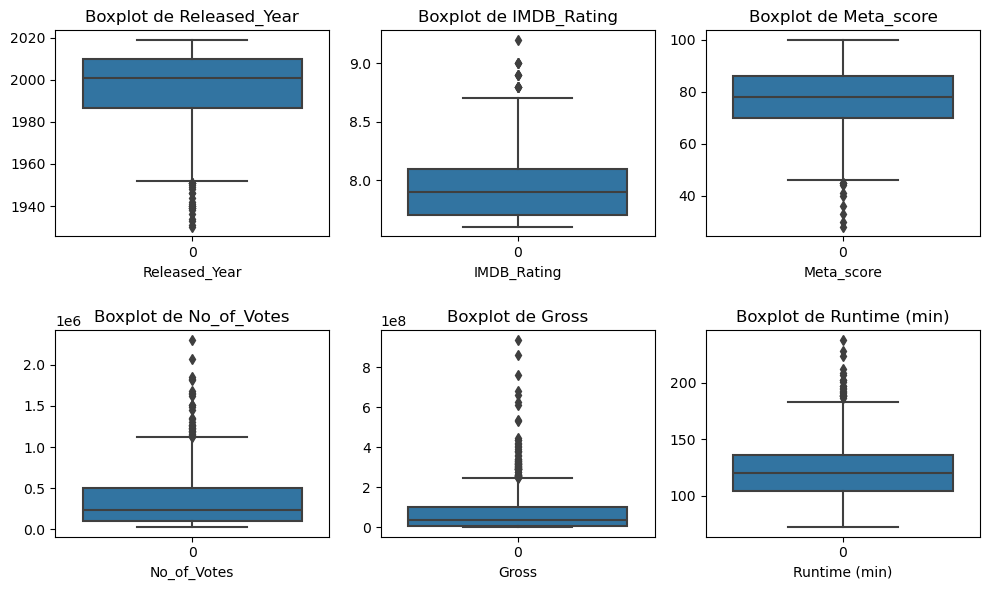

In [183]:
# Vizualização da distribuição dos percentis e outliers de cada atributo quantitativo
plt.figure(figsize=(10,6))
for column in quantitativas:
    n = quantitativas.index(column)+1
    plt.subplot(2,3,n)
    sns.boxplot(db_imdb[column])
    plt.title(f'Boxplot de {column}')
    plt.xlabel(column)
plt.tight_layout()
plt.savefig('../resultados/Boxplots.png')
plt.show()

## Histogramas

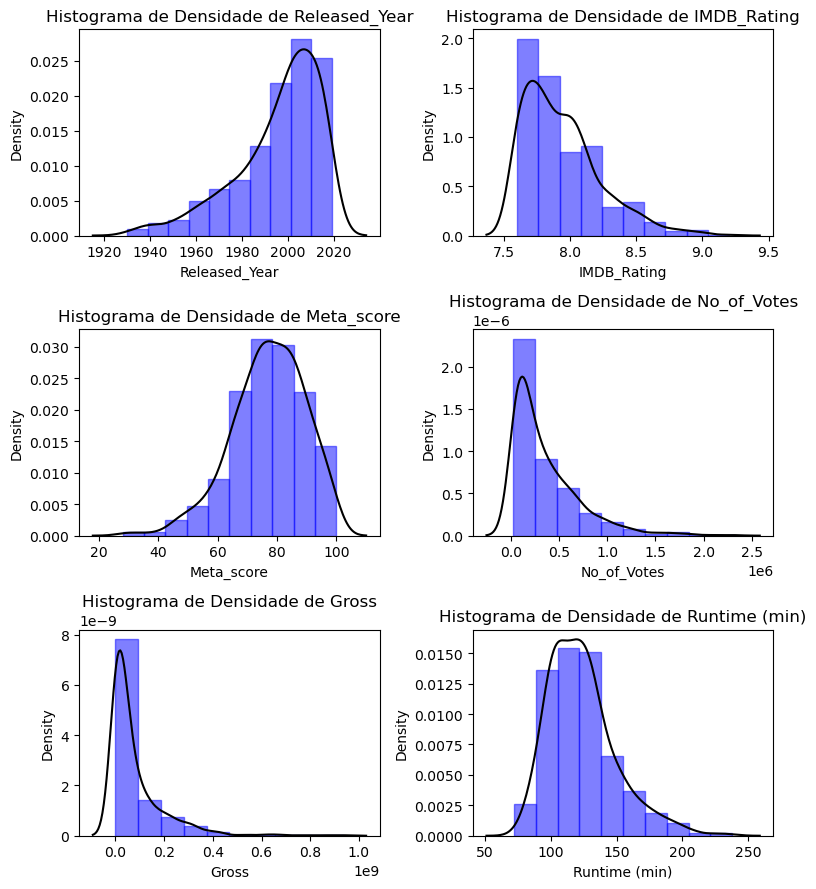

In [184]:
# Plotando histogramas para visualizar graficamente a distribuição de densidade de cada coluna quantitativa do dataset
plt.figure(figsize=(8,9))
for column in quantitativas:
    n = quantitativas.index(column)+1
    plt.subplot(3,2,n)
    plt.hist(data = db_imdb, x = column, color='blue', histtype='bar', rwidth=2, edgecolor='blue', density=True, alpha=.5)
    sns.kdeplot(db_imdb[column], color='black')
    plt.title(f'Histograma de Densidade de {column}')
    plt.xlabel(column)
plt.tight_layout()
plt.savefig('../resultados/Histogramas.png')
plt.show()

## Gráficos de Barra

In [185]:
# Criação de gráficos de barra para comparar a distribuição dos valores de cada coluna qualitativa
def graf_barra(y, x, titulo, **kwargs): # Função para criação dos gráficos e otimização do código
    plt.figure(figsize=(8,6))
    x, y = zip(*sorted(zip(x,y)))
    a = plt.barh(y, x, edgecolor='black',)
    plt.bar_label(a, padding=4, fontsize=9, **kwargs)
    plt.title(titulo)
    plt.savefig(f'../resultados/{titulo}.png')
    plt.show()

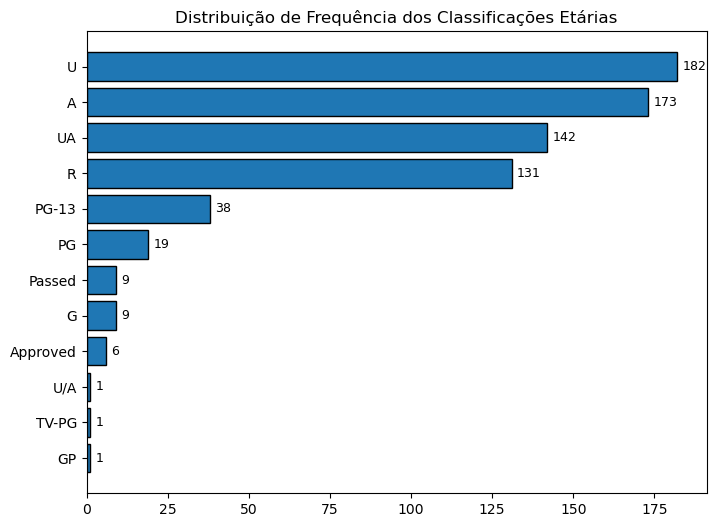

In [186]:
graf_barra(freq_certificate.index, freq_certificate['Frequência'], 'Distribuição de Frequência dos Classificações Etárias')

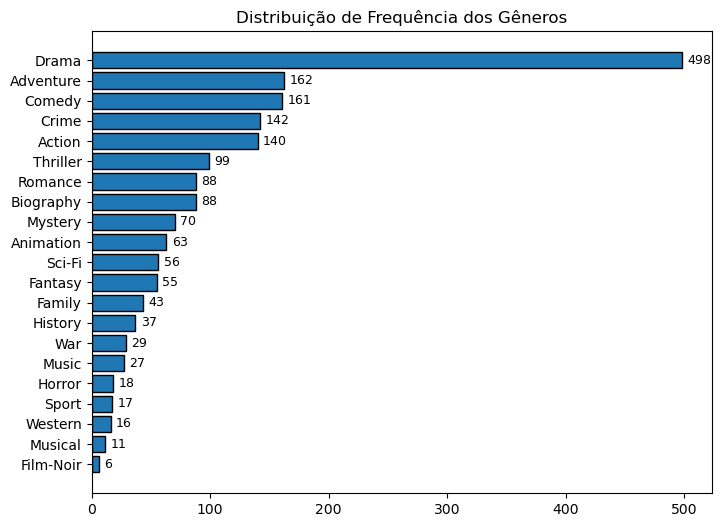

In [187]:
graf_barra(freq_genres.index, freq_genres['Frequência'], 'Distribuição de Frequência dos Gêneros')

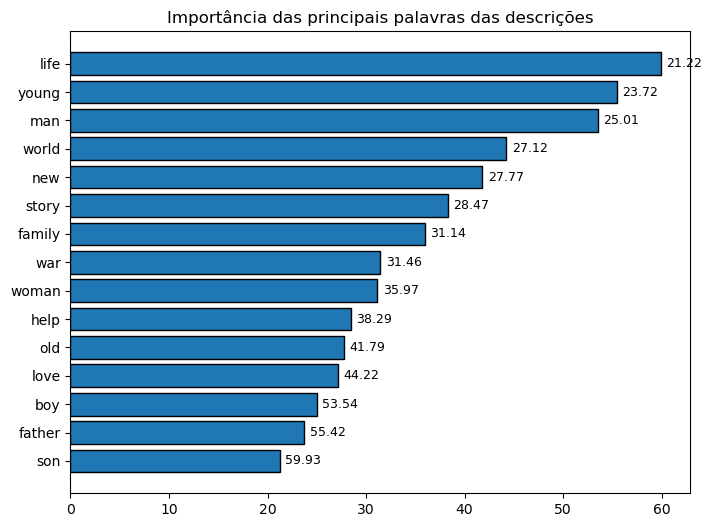

In [188]:
graf_barra(freq_overview_words.index, freq_overview_words['Importância Total'], 'Importância das principais palavras das descrições', labels=[f'{x:.2f}' for x in freq_overview_words['Importância Total']])

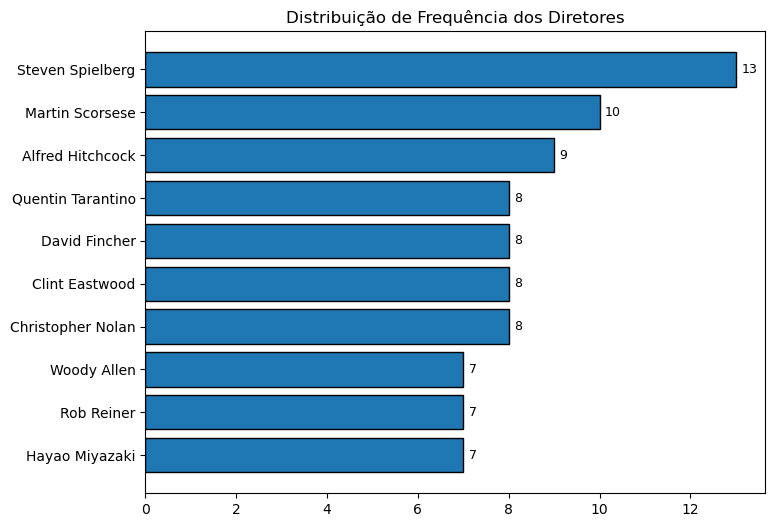

In [189]:
graf_barra(freq_director.index[:10], freq_director['Frequência'].iloc[:10], 'Distribuição de Frequência dos Diretores')

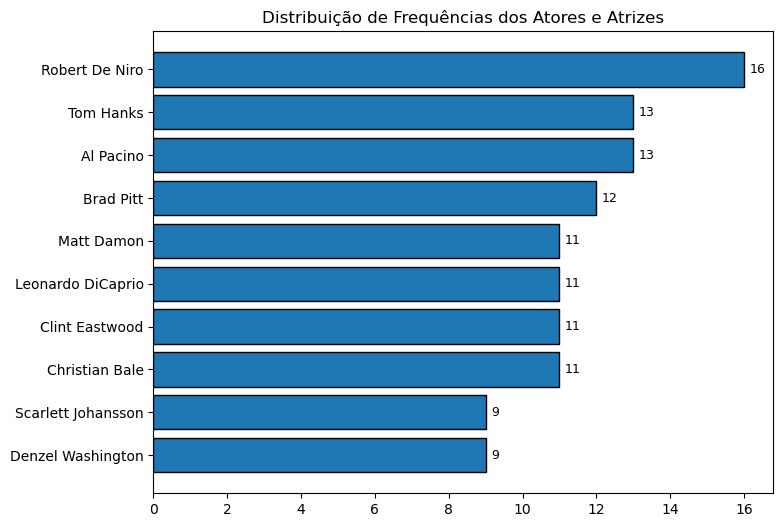

In [190]:
graf_barra(freq_stars.index[:10], freq_stars['Frequência'].iloc[:10], 'Distribuição de Frequências dos Atores e Atrizes')

# Análise Bivariada

## Correlação de Pearson

In [212]:
pearson = db_imdb[quantitativas].corr() # Cálculo do coeficiente de correlação de Pearson entre os atributos quantitativos
pearson.to_excel('../resultados/CorrPearson.xlsx', index=True)
pearson

,Released_Year,IMDB_Rating,Meta_score,No_of_Votes,Gross,Runtime (min)
Released_Year,1.000000,-0.178896,-0.272659,0.200074,0.234654,-0.017884
IMDB_Rating,-0.178896,1.000000,0.283994,0.609444,0.132396,0.258985
Meta_score,-0.272659,0.283994,1.000000,0.028575,-0.014656,-0.005938
No_of_Votes,0.200074,0.609444,0.028575,1.000000,0.561532,0.213211
Gross,0.234654,0.132396,-0.014656,0.561532,1.000000,0.168775
Runtime (min),-0.017884,0.258985,-0.005938,0.213211,0.168775,1.000000


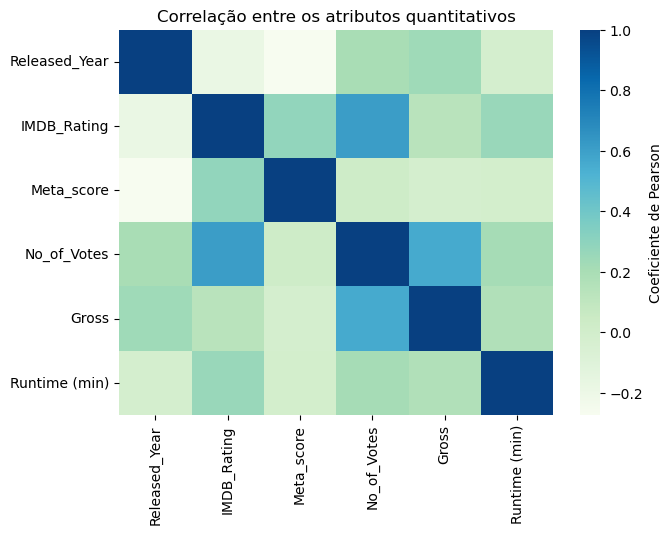

In [192]:
plt.figure(figsize=[7,5])
sns.heatmap(data=(db_imdb[quantitativas]).corr(), cmap='GnBu', fmt='.2f', cbar_kws={'label': 'Coeficiente de Pearson'})
plt.title('Correlação entre os atributos quantitativos')
plt.savefig('../resultados/CorrelaçãoPearson.png')
plt.show()

## Gráficos de Dispersão

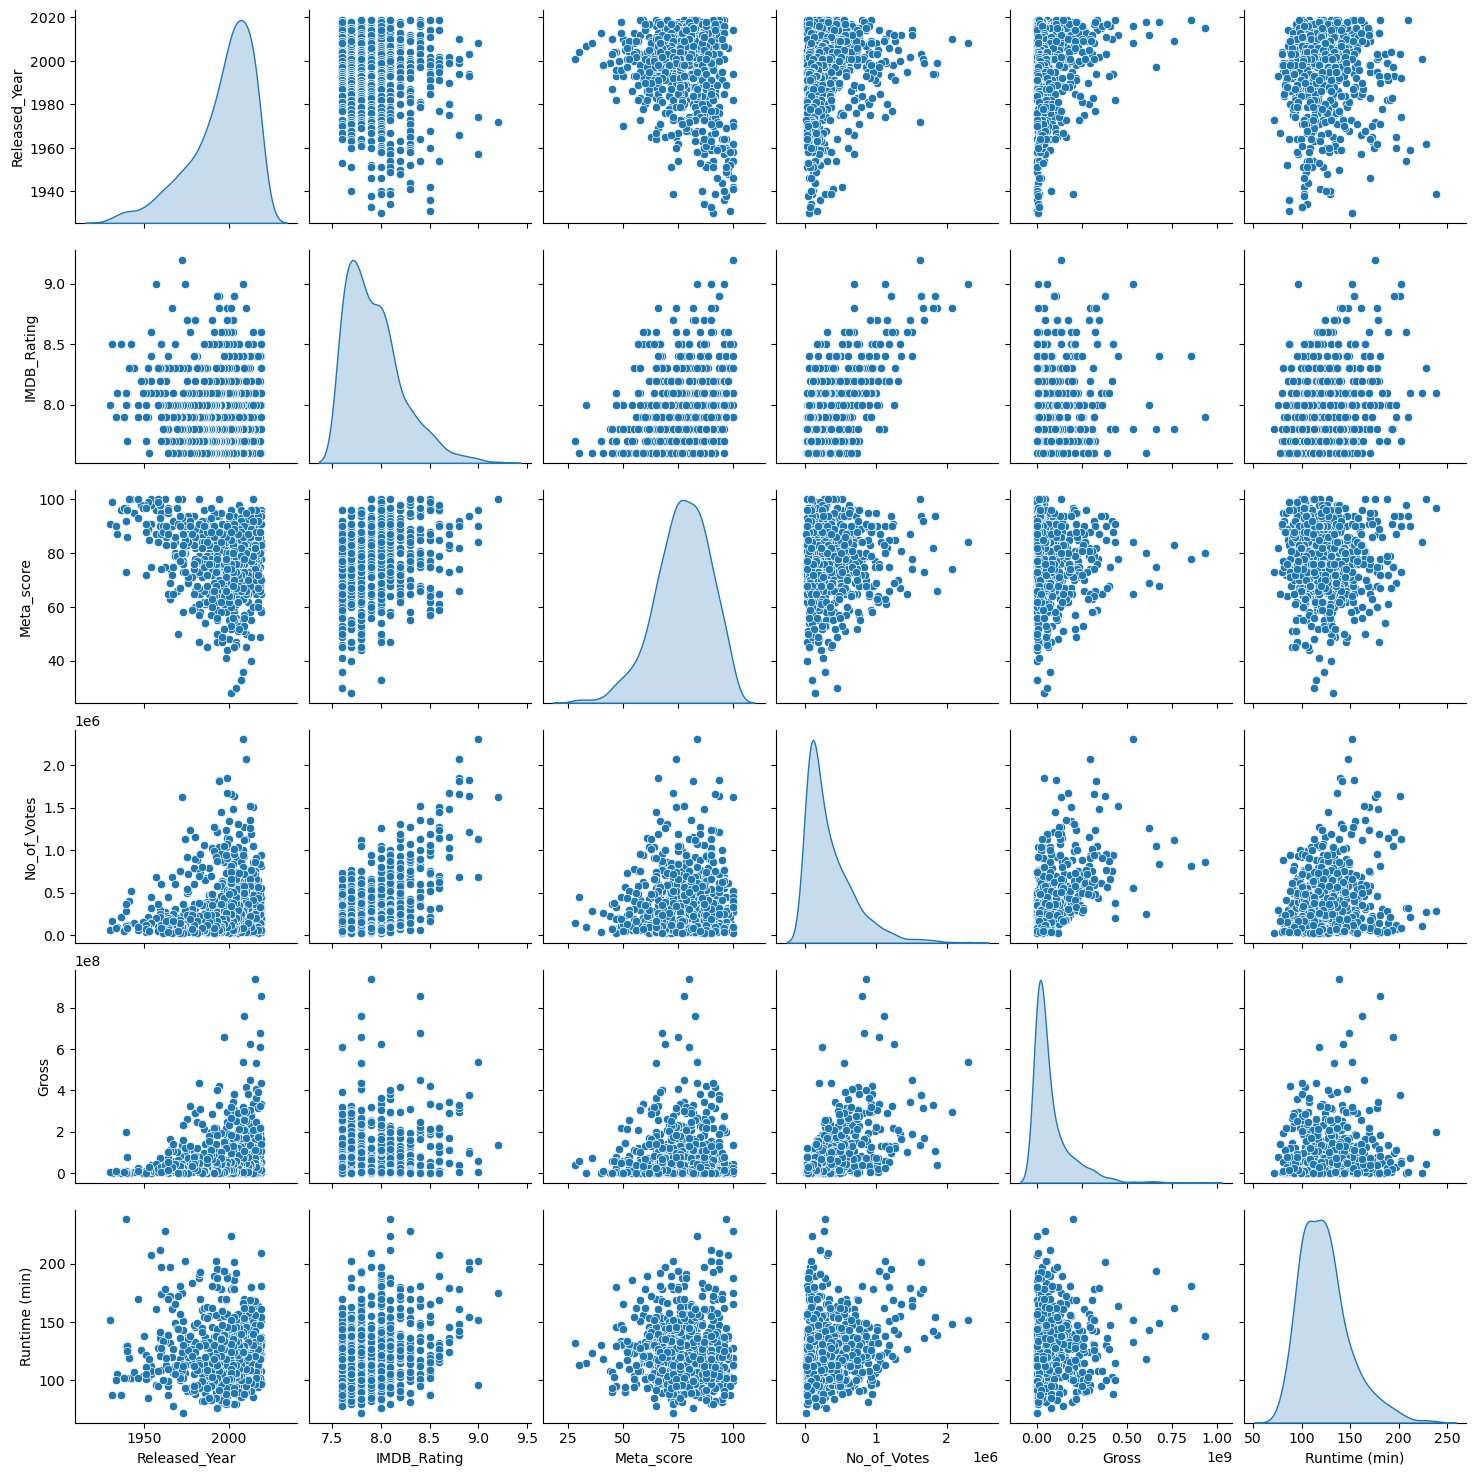

In [193]:
sns.pairplot(db_imdb[quantitativas], kind='scatter', diag_kind='kde') # Criação de gráficos do tipo scatter para cada combinação de atributos quantitativos para demonstrar graficamente como é sua associação
plt.savefig('../resultados/Dispersão.png')
plt.show()

## Comparação de atributos qualitativos

In [43]:
# Comparação entre os gêneros e as palavras extraidas pela técnica TF-IDF
df_overview_genre = pd.merge(df_overview, df_genre_exp, left_index=True, right_index=True) # Fazendo uma integração entre as colunas de importâncias das palavras extraídas pela vetorização e de todos os gêneros de cada filme
media_overview_genre = df_overview_genre.groupby('Genre').mean() # Apresentando a média das importâncias de cada palavra para cada gênero
media_overview_genre

,boy,family,father,help,life,love,man,new,old,son,story,war,woman,world,young
Genre,,,,,,,,,,,,,,,
Action,0.019522,0.046361,0.034350,0.059754,0.046186,0.007143,0.057709,0.053855,0.032158,0.016880,0.018464,0.061956,0.015631,0.071676,0.068356
Adventure,0.061740,0.050707,0.039967,0.059863,0.038828,0.012706,0.051943,0.063598,0.054603,0.014467,0.032987,0.049205,0.012639,0.106135,0.084294
Animation,0.084488,0.062896,0.038437,0.015873,0.042013,0.049995,0.048288,0.055504,0.081351,0.015873,0.009968,0.024737,0.016788,0.083662,0.150156
Biography,0.012025,0.019301,0.026956,0.023582,0.167156,0.011364,0.078362,0.057496,0.024071,0.022256,0.252574,0.064170,0.022146,0.069039,0.013970
Comedy,0.043434,0.060311,0.018215,0.034018,0.075666,0.060821,0.060994,0.072456,0.038539,0.026534,0.016166,0.006211,0.030795,0.040980,0.085324
Crime,0.021750,0.064226,0.027117,0.030251,0.049461,0.021698,0.070897,0.043904,0.013148,0.039020,0.061637,0.014085,0.023320,0.018051,0.068969
Drama,0.031358,0.051216,0.037826,0.036032,0.097900,0.042149,0.083616,0.057431,0.032393,0.035292,0.070617,0.056363,0.052047,0.063295,0.079467
Family,0.117365,0.127466,0.067402,0.069611,0.009190,0.071297,0.016803,0.060024,0.106378,0.014102,0.063203,0.000000,0.061838,0.077931,0.171319
Fantasy,0.064834,0.046919,0.051705,0.047386,0.031449,0.101530,0.112042,0.020678,0.000000,0.011423,0.040743,0.000000,0.023540,0.151028,0.111884


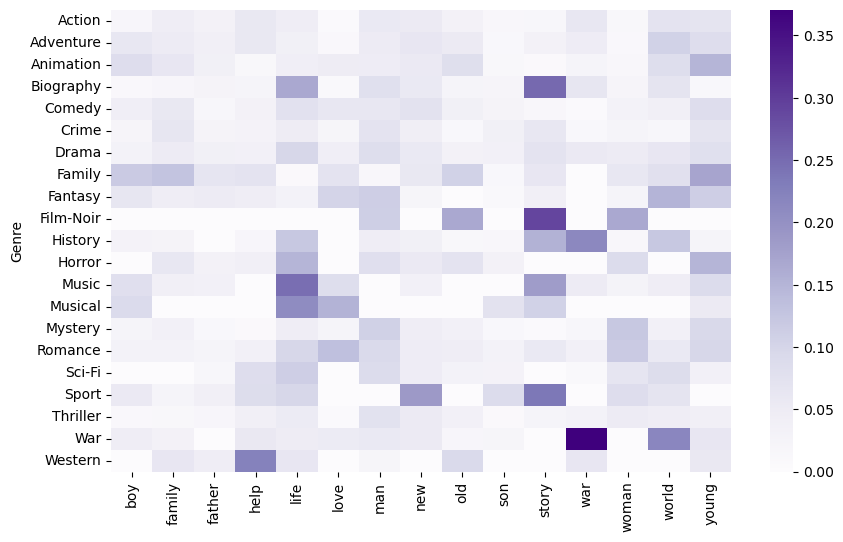

In [194]:
# Apresentação da importância média de cada palavra em função dos gêneros em um heatmap
plt.figure(figsize=(10,6))
sns.heatmap(media_overview_genre, cmap='Purples')
plt.savefig('../resultados/HeatmapImportânciaPalavrasGenero.png')
plt.show()

In [213]:
principal_palavra_genero = pd.DataFrame(media_overview_genre.idxmax(axis=1), columns=['Principal Palavra']) # Criando um dataframe com as palvras com maior importância para cada gênero
principal_palavra_genero.to_excel('../resultados/PrincipaisPalavrasPorGenero.xlsx', index=True)
principal_palavra_genero

,Principal Palavra
Genre,
Action,world
Adventure,world
Animation,young
Biography,story
Comedy,young
Crime,man
Drama,life
Family,young
Fantasy,world


# Inferência Estatística

## Teste de Normalidade

In [214]:
normalidade = pg.normality(db_imdb, method='normaltest').round(3) # Teste inferencial para verificar se os atributos quantitativos seguem uma distribuição normal
normalidade.to_excel('../resultados/TesteNormalidade.xlsx', index=True)
normalidade

,W,pval,normal
Released_Year,119.191,0.0,False
IMDB_Rating,122.521,0.0,False
Meta_score,40.898,0.0,False
No_of_Votes,268.552,0.0,False
Gross,475.325,0.0,False
Runtime (min),111.221,0.0,False


In [215]:
df_curt_obliq = pd.DataFrame({'Obliquidade': db_imdb[quantitativas].skew(), # Verificação da obliquidade dos atributos, que indica se há a presença de assimetrias na distribuição e qual sua direção
                              'Curtose': db_imdb[quantitativas].kurtosis() # Verificação da curtose dos atributos, que indica a existência ou não de picos ou achatamentos na distribuição
                             }, index = quantitativas)
df_curt_obliq.to_excel('../resultados/ObliquidadeCurtose.xlsx', index=True)
df_curt_obliq

,Obliquidade,Curtose
Released_Year,-1.146066,0.926881
IMDB_Rating,1.116874,1.270137
Meta_score,-0.584247,0.483403
No_of_Votes,1.820960,4.228842
Gross,2.927656,12.223772
Runtime (min),1.014108,1.375267


## Gráfico QQ-Plot

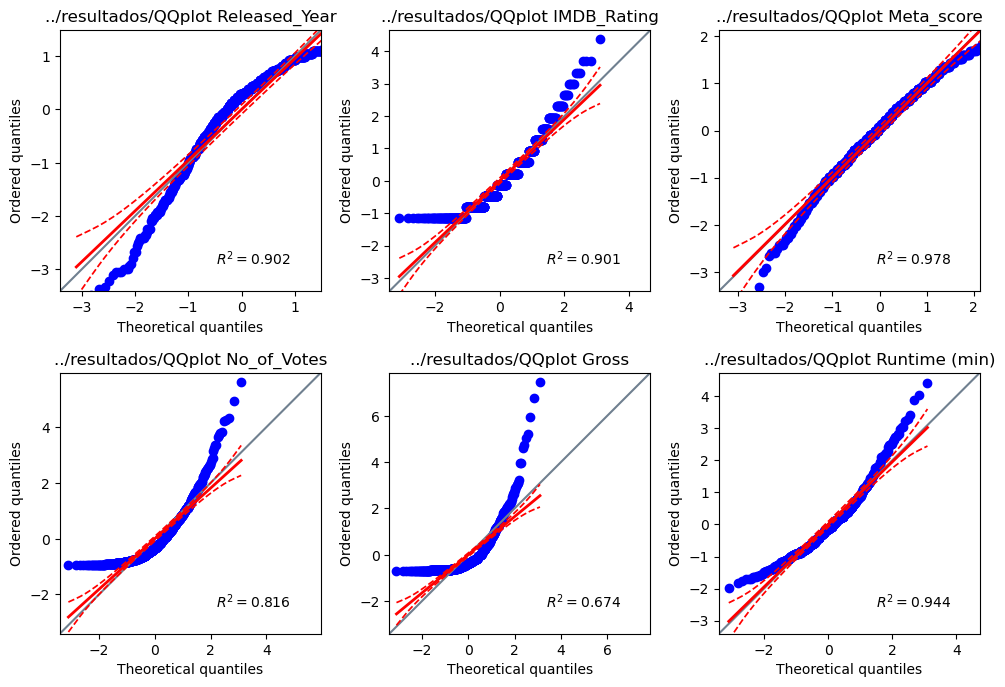

In [198]:
# Plotando gráficos QQ-plot como outra ferramenta para verificação da normalidaade de distribuição dos atributos
plt.figure(figsize = (10,7))
n = 0
for column in quantitativas:
    n += 1
    plt.subplot(2,3,n)
    pg.qqplot(db_imdb[column], dist='norm')
    plt.title(f'../resultados/QQplot {column}')
plt.tight_layout()
plt.savefig('QQPlot.png')
plt.show()

## Testes de Correlação

In [160]:
spearman = pg.pairwise_corr(db_imdb, method='spearman').round(3) # Teste de correlação de Spearman
spearman

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,Released_Year,IMDB_Rating,spearman,two-sided,712,-0.151,"[-0.22, -0.08]",0.000,0.982
1,Released_Year,Meta_score,spearman,two-sided,712,-0.173,"[-0.24, -0.1]",0.000,0.996
2,Released_Year,No_of_Votes,spearman,two-sided,712,0.233,"[0.16, 0.3]",0.000,1.000
3,Released_Year,Gross,spearman,two-sided,712,0.180,"[0.11, 0.25]",0.000,0.998
4,Released_Year,Runtime (min),spearman,two-sided,712,0.049,"[-0.02, 0.12]",0.189,0.259
5,IMDB_Rating,Meta_score,spearman,two-sided,712,0.290,"[0.22, 0.36]",0.000,1.000
6,IMDB_Rating,No_of_Votes,spearman,two-sided,712,0.400,"[0.34, 0.46]",0.000,1.000
7,IMDB_Rating,Gross,spearman,two-sided,712,0.031,"[-0.04, 0.1]",0.407,0.132
8,IMDB_Rating,Runtime (min),spearman,two-sided,712,0.214,"[0.14, 0.28]",0.000,1.000
9,Meta_score,No_of_Votes,spearman,two-sided,712,-0.012,"[-0.09, 0.06]",0.745,0.062


In [161]:
kendall = pg.pairwise_corr(db_imdb, method='kendall').round(3) # Teste de correlação de Kendall
kendall

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,Released_Year,IMDB_Rating,kendall,two-sided,712,-0.106,"[-0.18, -0.03]",0.000,0.811
1,Released_Year,Meta_score,kendall,two-sided,712,-0.118,"[-0.19, -0.04]",0.000,0.883
2,Released_Year,No_of_Votes,kendall,two-sided,712,0.155,"[0.08, 0.23]",0.000,0.987
3,Released_Year,Gross,kendall,two-sided,712,0.125,"[0.05, 0.2]",0.000,0.915
4,Released_Year,Runtime (min),kendall,two-sided,712,0.034,"[-0.04, 0.11]",0.179,0.149
5,IMDB_Rating,Meta_score,kendall,two-sided,712,0.211,"[0.14, 0.28]",0.000,1.000
6,IMDB_Rating,No_of_Votes,kendall,two-sided,712,0.287,"[0.22, 0.35]",0.000,1.000
7,IMDB_Rating,Gross,kendall,two-sided,712,0.020,"[-0.05, 0.09]",0.441,0.084
8,IMDB_Rating,Runtime (min),kendall,two-sided,712,0.152,"[0.08, 0.22]",0.000,0.983
9,Meta_score,No_of_Votes,kendall,two-sided,712,-0.009,"[-0.08, 0.06]",0.730,0.056


In [199]:
testes_corr = pd.DataFrame({'X': spearman['X'],
                            'Y': spearman['Y'],
                            'P-valor de Spearman': spearman['p-unc'],
                            'P-valor de Kendall': kendall['p-unc']})
testes_corr.to_excel('../resultados/TestesCorrelaçãoSK.xlsx', index=False)
testes_corr

,X,Y,P-valor de Spearman,P-valor de Kendall
0,Released_Year,IMDB_Rating,0.000,0.000
1,Released_Year,Meta_score,0.000,0.000
2,Released_Year,No_of_Votes,0.000,0.000
3,Released_Year,Gross,0.000,0.000
4,Released_Year,Runtime (min),0.189,0.179
5,IMDB_Rating,Meta_score,0.000,0.000
6,IMDB_Rating,No_of_Votes,0.000,0.000
7,IMDB_Rating,Gross,0.407,0.441
8,IMDB_Rating,Runtime (min),0.000,0.000
9,Meta_score,No_of_Votes,0.745,0.730


## Teste de Mann-Whitney

### Faturamento em diferentes períodos

In [49]:
# Amostras antes e depois de 1995 (média)
ano_menor_media = db_imdb[db_imdb['Released_Year']<= db_imdb['Released_Year'].mean()]['Gross'] # Amostra do faturamento para os anos menores que o ano médio
ano_maior_media = db_imdb[db_imdb['Released_Year']>= db_imdb['Released_Year'].mean()]['Gross'] # Amostra do faturamento para os anos maiores que o ano médio
u_stat, p_valor = stats.mannwhitneyu(ano_menor_media, ano_maior_media) # Aplicação do teste de Mann-Whitney nas amostras de faturamento
print('Teste de Mann-Whitney:\nEstatística U =', u_stat, ',\nP-Valor =', p_valor.round(3)) # Imprimindo os resultados

Teste de Mann-Whitney:
Estatística U = 53734.0 ,
P-Valor = 0.013


In [50]:
# Amostras de 2015 e 2019
ano_2019 = db_imdb[db_imdb['Released_Year']==2019]['Gross'] # Amostra do faturamento no ano de 2019
ano_2015 = db_imdb[db_imdb['Released_Year']==2015]['Gross'] # Amostra do faturamento no ano de 2015
u_stat, p_valor = stats.mannwhitneyu(ano_2019, ano_2015) # Aplicação do teste de Mann-Whitney
print('Teste de Mann-Whitney:\nEstatística U =', u_stat, ',\nP-Valor =', p_valor.round(3)) # Imprimindo os resultados

Teste de Mann-Whitney:
Estatística U = 141.0 ,
P-Valor = 0.842


### Número de votos para diferentes faturamentos

In [51]:
fat_q1 = db_imdb['Gross'].quantile(0.25)
fat_q3 = db_imdb['Gross'].quantile(0.75)

In [52]:
fat_primeiro_q = db_imdb[db_imdb['Gross']< fat_q1]['No_of_Votes'] # Amostra do número de votos com faturamento abaixo do primeiro quartil de faturamento
fat_extremo = db_imdb[db_imdb['Gross']> fat_q3]['No_of_Votes'] # Amostra do número de votos com faturamento acimea do terceiro quartil de faturamento
u_stat, p_valor = stats.mannwhitneyu(fat_primeiro_q , fat_extremo) # Aplicação do teste de Mann-Whitney
print('Teste de Mann-Whitney:\nEstatística U =', u_stat, ',\nP-Valor =', p_valor.round(3)) # Imprimindo os resultados

Teste de Mann-Whitney:
Estatística U = 1860.0 ,
P-Valor = 0.0


# Aplicação de algoritmos de Machine Learning

## Tratamentos dos dados para manipulações com números

In [48]:
db_imdb_tr = db_imdb.copy() # Criação de uma cópia do banco de dados para realização das transformações

### Separando as categorias de gênero de filme

In [49]:
top_genres = ['Drama', 'Adventure', 'Comedy', 'Crime'] # Selecionando os 4 principais gêneros
def generos(db):
    for genre in top_genres:
        db[f'Genre{genre}'] = db['Genre'].apply(lambda x: 1 if genre in x else 0) # Criando uma coluna binária para cada um dos gêneros principais
    db['GenreOthers'] = db['Genre'].apply(lambda x: 1 if any(genre not in top_genres for genre in x) else 0) # Criando uma coluna binária para indicar a presença ou ausência de gêneros que não são os 4 principais
    db.drop(columns='Genre', inplace=True)
generos(db_imdb_tr)
db_imdb_tr[['GenreDrama', 'GenreAdventure', 'GenreComedy', 'GenreCrime', 'GenreOthers']] # Visualização das colunas geradas

,GenreDrama,GenreAdventure,GenreComedy,GenreCrime,GenreOthers
0,1,0,0,1,0
1,1,0,0,1,1
2,1,0,0,1,0
3,1,0,0,1,0
4,1,1,0,0,1
...,...,...,...,...,...
989,1,0,0,0,1
990,0,1,1,0,1
991,0,1,0,0,1
993,0,0,1,0,1


### Adicionando as colunas das palavras extraídas do 'Overview'

In [50]:
db_imdb_tr = pd.concat([db_imdb_tr, df_overview], axis=1)
db_imdb_tr.drop(columns='Overview', inplace=True)
db_imdb_tr

,Series_Title,Released_Year,Certificate,IMDB_Rating,Meta_score,Director,Star1,Star2,Star3,Star4,...,love,man,new,old,son,story,war,woman,world,young
0,The Godfather,1972,A,9.2,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,...,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0
1,The Dark Knight,2008,UA,9.0,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,The Godfather: Part II,1974,A,9.0,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,...,0.0,0.0,0.482869,0.0,0.569629,0.0,0.0,0.0,0.0,0.0
3,12 Angry Men,1957,U,9.0,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,The Lord of the Rings: The Return of the King,2003,U,8.9,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,Giù la testa,1971,PG,7.6,77.0,Sergio Leone,Rod Steiger,James Coburn,Romolo Valli,Maria Monti,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
990,Kelly's Heroes,1970,GP,7.6,50.0,Brian G. Hutton,Clint Eastwood,Telly Savalas,Don Rickles,Carroll O'Connor,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
991,The Jungle Book,1967,U,7.6,65.0,Wolfgang Reitherman,Phil Harris,Sebastian Cabot,Louis Prima,Bruce Reitherman,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
993,A Hard Day's Night,1964,U,7.6,96.0,Richard Lester,John Lennon,Paul McCartney,George Harrison,Ringo Starr,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


### Separando os atributos previsores e preditivos

In [51]:
titulo = db_imdb_tr['Series_Title']
X = db_imdb_tr.drop(columns=['Series_Title', 'IMDB_Rating'])
y = pd.DataFrame(db_imdb_tr['IMDB_Rating'])

### Codificação dos atributos categóricos

In [52]:
le_director = LabelEncoder()
X['Director'] = le_director.fit_transform(X['Director'])
X['Director']

0      100
1       59
2      100
3      338
4      286
      ... 
989    335
990     44
991    392
993    302
996    106
Name: Director, Length: 712, dtype: int32

In [53]:
le_stars = LabelEncoder()
stars = df_stars.unique()
stars = le_stars.fit_transform(stars)
columns_stars = ['Star1', 'Star2', 'Star3', 'Star4']
for column in columns_stars:
    X[column] = le_stars.transform(X[column])
X[columns_stars]

,Star1,Star2,Star3,Star4
0,1185,21,743,424
1,310,660,1,1247
2,21,1516,1518,424
3,670,1066,1187,880
4,483,1823,702,1371
...,...,...,...,...
989,1534,744,1547,1162
990,338,1726,441,260
991,1434,1635,1120,226
993,893,1403,600,1506


In [54]:
le_certificate = LabelEncoder()
X['Certificate'] = le_certificate.fit_transform(X['Certificate'])
X['Certificate']

0       0
1      11
2       0
3       9
4       9
       ..
989     4
990     3
991     9
993     9
996     6
Name: Certificate, Length: 712, dtype: int32

### Padronização dos atributos quantitativos

In [55]:
scaler = StandardScaler()
quant_scal = ['Released_Year', 'Meta_score', 'No_of_Votes', 'Gross', 'Runtime (min)']
X[quant_scal] = scaler.fit_transform(X[quant_scal])
X[quant_scal]

,Released_Year,Meta_score,No_of_Votes,Gross,Runtime (min)
0,-1.276407,1.840985,3.659376,0.491498,1.982775
1,0.659273,0.551639,5.631795,3.969189,1.094381
2,-1.168870,1.035144,2.242838,-0.183934,3.025672
3,-2.082941,1.518649,0.971612,-0.644331,-1.068666
4,0.390429,1.357480,3.724051,2.603717,2.987047
...,...,...,...,...,...
989,-1.330176,-0.012450,-0.933899,-0.676189,1.287510
990,-1.383945,-2.188221,-0.890012,-0.670260,0.785374
991,-1.545252,-0.979459,-0.540305,0.551306,-1.763931
993,-1.706559,1.518649,-0.904417,-0.562409,-1.416299


In [56]:
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y)
y = y.ravel()
y[:10]

array([ 4.37899519,  3.68629477,  3.68629477,  3.68629477,  3.33994456,
        3.33994456,  3.33994456,  2.99359435,  2.99359435,  2.99359435,
        2.99359435,  2.99359435,  2.64724415,  2.64724415,  2.64724415,
        2.64724415,  2.64724415,  2.30089394,  2.30089394,  2.30089394,
        2.30089394,  2.30089394,  2.30089394,  2.30089394,  2.30089394,
        2.30089394,  2.30089394,  2.30089394,  1.95454373,  1.95454373,
        1.95454373,  1.95454373,  1.95454373,  1.95454373,  1.95454373,
        1.95454373,  1.95454373,  1.95454373,  1.95454373,  1.95454373,
        1.95454373,  1.95454373,  1.95454373,  1.95454373,  1.95454373,
        1.95454373,  1.95454373,  1.60819352,  1.60819352,  1.60819352,
        1.60819352,  1.60819352,  1.60819352,  1.60819352,  1.60819352,
        1.60819352,  1.60819352,  1.60819352,  1.60819352,  1.60819352,
        1.60819352,  1.60819352,  1.60819352,  1.60819352,  1.60819352,
        1.60819352,  1.60819352,  1.26184331,  1.26184331,  1.26

### Visualização das alterações feitas

In [57]:
X.head(5)

,Released_Year,Certificate,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,...,love,man,new,old,son,story,war,woman,world,young
0,-1.276407,0,1.840985,100,1185,21,743,424,3.659376,0.491498,...,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0
1,0.659273,11,0.551639,59,310,660,1,1247,5.631795,3.969189,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,-1.168870,0,1.035144,100,21,1516,1518,424,2.242838,-0.183934,...,0.0,0.0,0.482869,0.0,0.569629,0.0,0.0,0.0,0.0,0.0
3,-2.082941,9,1.518649,338,670,1066,1187,880,0.971612,-0.644331,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.390429,9,1.357480,286,483,1823,702,1371,3.724051,2.603717,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0


In [58]:
y[:10]

array([4.37899519, 3.68629477, 3.68629477, 3.68629477, 3.33994456,
       3.33994456, 3.33994456, 2.99359435, 2.99359435, 2.99359435])

### Divisão dos dados

In [59]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.10)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.20)

In [60]:
X_train.shape, X_val.shape, X_test.shape

((512, 31), (128, 31), (72, 31))

In [61]:
y_train.shape, y_val.shape, y_test.shape

((512,), (128,), (72,))

## Validação Cruzada

In [64]:
# Validação cruzada para selecionar os modelos com melhor desempenho
reg_models = {'Regressão Linear': LinearRegression(),
              'Lasso': Lasso(),
              'Ridge': Ridge(),
              'Random Forest': RandomForestRegressor(),
              'MLP': MLPRegressor(max_iter=5000),
              'Árvore de Decisão': DecisionTreeRegressor(),
              'SVM': SVR(),
              'Gradient Boosting': GradientBoostingRegressor(),
              'AdaBoost': AdaBoostRegressor()
             } # Dicionário contendo os modelos de regressão a serem testados pela validação cruzada

results = {'Modelo': [],
            'NRMSE Médio': [],
            'Desvio Padrão': []} # Dicionário que armazenará os resultados da validação cruzada

kfold = KFold(n_splits=10, random_state=42, shuffle=True) # Número de folds

for name, model in reg_models.items():
    cv_rmse = cross_val_score(model, X_val, y_val, cv=kfold, scoring='neg_root_mean_squared_error') # Validação cruzada usando como score o root mean squared error negativo
    results['Modelo'].append(name)
    results['NRMSE Médio'].append(np.mean(cv_rmse))
    results['Desvio Padrão'].append(np.std(cv_rmse))

### Comparação dos modelos

In [200]:
df_cv_results = pd.DataFrame(results)
df_cv_results = df_cv_results.sort_values(by='NRMSE Médio', ascending=False)
df_cv_results.to_excel('../resultados/ComparaçãoModelos.xlsx', index=False)
df_cv_results # Exibindo os resultados em um dataframe

,Modelo,NRMSE Médio,Desvio Padrão
2,Ridge,-0.719880,0.075844
0,Regressão Linear,-0.750873,0.088725
3,Random Forest,-0.767249,0.156734
7,Gradient Boosting,-0.817628,0.098348
8,AdaBoost,-0.820469,0.160432
1,Lasso,-0.957342,0.229397
6,SVM,-0.979862,0.229786
5,Árvore de Decisão,-0.991363,0.226164
4,MLP,-27.127098,32.016057


## Aperfeiçoamento dos modelos

In [68]:
# Aplicação do algoritmo optuna para otimização dos hiperparâmetros dos 4 modelos com melhor desempenho na validação cruzada
def objective(modelo, trial): # Criação da função objetivo
    if modelo == 'Ridge': # Selecionando o espaço de hiperparâmetros a serem testados no modelo Ridge
        alpha = trial.suggest_float('alpha', 1e-5, 10, log=True)
        model = Ridge(alpha=alpha)
    elif modelo == 'Gradient Boosting': # Selecionando o espaço de hiperparâmetros a serem testados no modelo Gradient Boosting
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 1, log=True)
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        model = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators, random_state=42)
    elif modelo == 'Random Forest': # Selecionando o espaço de hiperparâmetros a serem testados no modelo Random Forest
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    
    score = np.mean(cross_val_score(model, X_val, y_val, cv=kfold, scoring='neg_root_mean_squared_error')) # Validação cruzada
    
    return score

def modelo_optuna(model): # Criando a função que vai executar o optuna para cada modelo
    study = optuna.create_study(direction='minimize') # Criando um estudo do optuna para minimizar o score
    optuna.logging.set_verbosity(optuna.logging.WARNING) # Alterando o nível de verbosidade
    study.optimize(lambda trial: objective(model, trial), n_trials=50) # Implementando o algoritmo
    teste = study.best_trial
    print(f"Melhor teste para: {model}\nValor: {teste.value}\nParâmetros: {study.best_params}")
    return study.best_params

In [69]:
ridge_params = modelo_optuna('Ridge') # Otimização dos hiperparâmetros do modelo Ridge

[I 2024-07-07 11:32:45,812] A new study created in memory with name: no-name-7991d181-db49-4145-88b3-25761e567421


Melhor teste para: Ridge
Valor: -0.7508728313166808
Parâmetros: {'alpha': 1.013539446895389e-05}


In [70]:
gb_params = modelo_optuna('Gradient Boosting') # Otimização dos hiperparâmetros do modelo Gradient Boosting

Melhor teste para: Gradient Boosting
Valor: -0.973554151816964
Parâmetros: {'learning_rate': 0.00019214144074759467, 'n_estimators': 50}


In [71]:
rf_params = modelo_optuna('Random Forest') # Otimização dos hiperparâmetros do modelo Random Forest

Melhor teste para: Random Forest
Valor: -0.79512375444405
Parâmetros: {'n_estimators': 113, 'max_depth': 3}


## Implementação do Stacking

In [72]:
# Utilização do método stacking para combinar os 4 melhores modelos a fim de otimizar o resultado previsto
base_modelos = [('lr', LinearRegression()),
          ('ridge', Ridge(**ridge_params)),
          ('rf', RandomForestRegressor(**rf_params)),
          ('gb', GradientBoostingRegressor(**gb_params))] # Listando os modelos de base do stacking com os hiperparâmetros ajustados pelo optuna

meta_modelo = GradientBoostingRegressor() # Definição do meta modelo do stacking

stacking_reg = StackingRegressor(estimators=base_modelos, final_estimator=meta_modelo) # Definição do stacking
stacking_reg.fit(X_train, y_train) # Treinamento do stacking

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('ridge', Ridge(alpha=1.013539446895389e-05)),
                              ('rf',
                               RandomForestRegressor(max_depth=3,
                                                     n_estimators=113)),
                              ('gb',
                               GradientBoostingRegressor(learning_rate=0.00019214144074759467,
                                                         n_estimators=50))],
                  final_estimator=GradientBoostingRegressor())

In [111]:
# Salvando o modelo stacking em um arquivo pkl
with open('stacking_reg.pkl', 'wb') as arquivo:
    pickle.dump(stacking_reg, arquivo)

## Previsões

In [ ]:
# Lendo o modelo stacking salvo em um arquivo pkl
# with open('stacking_reg.pkl', 'rb') as arquivo:
#    stacking_reg = pickle.load(arquivo)

In [78]:
y_test_pred = stacking_reg.predict(X_test) # Prevendo os valores do conjunto de teste

In [82]:
y_test_pred_inv = (scaler_y.inverse_transform(y_test_pred.reshape(-1,1))).ravel() # Desfazendo a padronização das predições
y_test_pred_inv[:10]

array([8.21482601, 7.87997858, 7.85204039, 8.80250914, 7.96238138,
       7.86908588, 7.91036122, 8.55607827, 7.84772361, 7.93562088])

### Comparações

In [201]:
y_test_inv = (scaler_y.inverse_transform(y_test.reshape(-1,1))).ravel() # Desfazendo a padronização dos valores previstos do conjunto de teste
comp_test = pd.DataFrame({'Titulo': titulo[X_test.index],
                         'Valor Real': y_test_inv,
                         'Valor Previsto': y_test_pred_inv}, index=X_test.index) # Criando um DataFrame para comparar os valores reais e previstos de cada filme
comp_test.iloc[:10].to_excel('../resultados/ComparaçõesRealPredições.xlsx', index=False)
comp_test.iloc[:10]

,Titulo,Valor Real,Valor Previsto
108,Star Wars: Episode VI - Return of the Jedi,8.3,8.214826
644,Wo hu cang long,7.8,7.879979
793,Hedwig and the Angry Inch,7.7,7.852040
10,Forrest Gump,8.8,8.802509
114,Per qualche dollaro in più,8.3,7.962381
991,The Jungle Book,7.6,7.869086
935,Un long dimanche de fiançailles,7.6,7.910361
23,Saving Private Ryan,8.6,8.556078
816,Short Cuts,7.7,7.847724
587,Le passé,7.8,7.935621


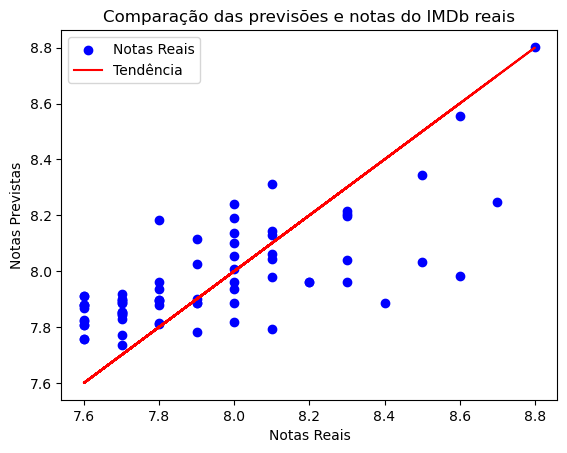

In [202]:
# Gráfico de comparação entre as nota reais do IMDb e as previsões
plt.scatter(y_test_inv, y_test_pred_inv, color='blue', label='Notas Reais')
plt.plot(y_test_inv, y_test_inv, color='red', label='Tendência')
plt.xlabel('Notas Reais')
plt.ylabel('Notas Previstas')
plt.title('Comparação das previsões e notas do IMDb reais')
plt.legend()
plt.savefig('../resultados/GráficoComparaçõesNotas.png')
plt.show()

## Métricas

In [85]:
print('Métricas para o conjunto de teste\nErro quadrático médio:', mean_squared_error(y_test_inv, y_test_pred_inv), '\nErro absoluto médio:', mean_absolute_error(y_test_inv, y_test_pred_inv))

Métricas para o conjunto de teste
Erro quadrático médio: 0.04389540074329309 
Erro absoluto médio: 0.1691578978753473


## Importância e Coeficientes dos Atributos

In [113]:
gb_importances = stacking_reg.named_estimators_['gb'].feature_importances_
rf_importances = stacking_reg.named_estimators_['rf'].feature_importances_
ridge_coef = stacking_reg.named_estimators_['ridge'].coef_
lr_coef = stacking_reg.named_estimators_['lr'].coef_

df_importances = pd.DataFrame({'Random Forest': rf_importances.round(3),
                               'Gradient Boosting': gb_importances.round(3),
                               'Média das Importâncias': np.mean(np.stack((gb_importances, rf_importances)), axis=0).round(3),
                               'Ridge': ridge_coef.round(3),
                               'Regressão Linear': lr_coef.round(3),
                               'Média dos Coeficientes': np.mean(np.stack((ridge_coef, lr_coef)), axis=0).round(3)
                                }, index=X.columns)
df_importances = df_importances.sort_values(by='Média dos Coeficientes', ascending=False)
df_importances

,Random Forest,Gradient Boosting,Média das Importâncias,Ridge,Regressão Linear,Média dos Coeficientes
No_of_Votes,0.747,0.798,0.773,0.788,0.788,0.788
son,0.001,0.000,0.001,0.565,0.565,0.565
boy,0.000,0.000,0.000,0.418,0.418,0.418
love,0.002,0.000,0.001,0.270,0.270,0.270
help,0.002,0.000,0.001,0.258,0.258,0.258
war,0.002,0.000,0.001,0.224,0.224,0.224
new,0.000,0.000,0.000,0.178,0.178,0.178
Meta_score,0.065,0.038,0.051,0.171,0.171,0.171
GenreDrama,0.000,0.000,0.000,0.163,0.163,0.163
old,0.000,0.000,0.000,0.141,0.141,0.141


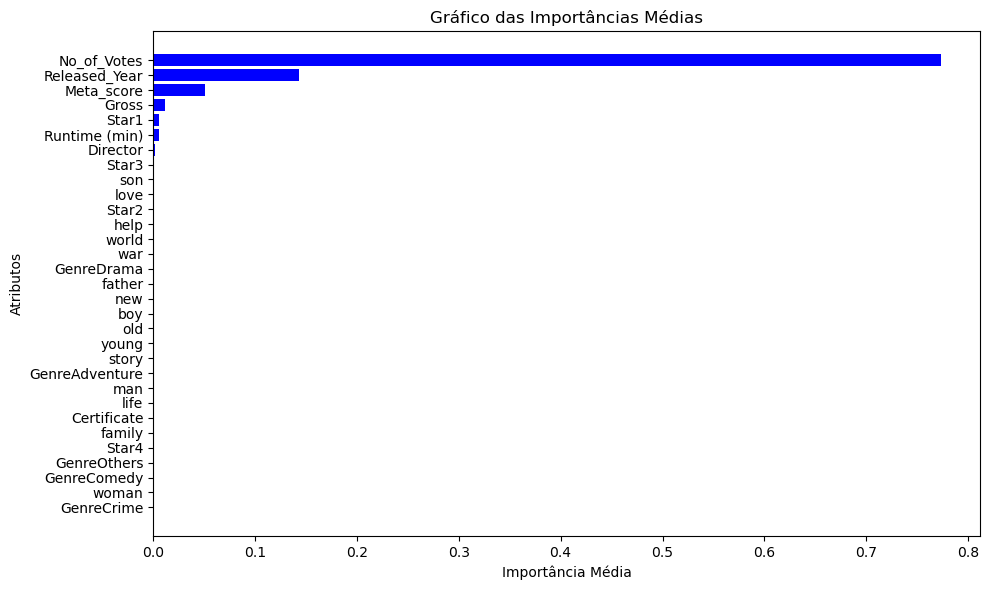

In [203]:
# Plotando um gráfico para comparação das importâncias médias de caada atributo
importances = df_importances['Média das Importâncias'].sort_values()
plt.figure(figsize=(10,6))
imp_graf = plt.barh(importances.index, importances, color='b')
plt.xlabel('Importância Média')
plt.ylabel('Atributos')
plt.title('Gráfico das Importâncias Médias')
plt.tight_layout()
plt.savefig('../resultados/GráficoImportânciasMédias.png')
plt.show()

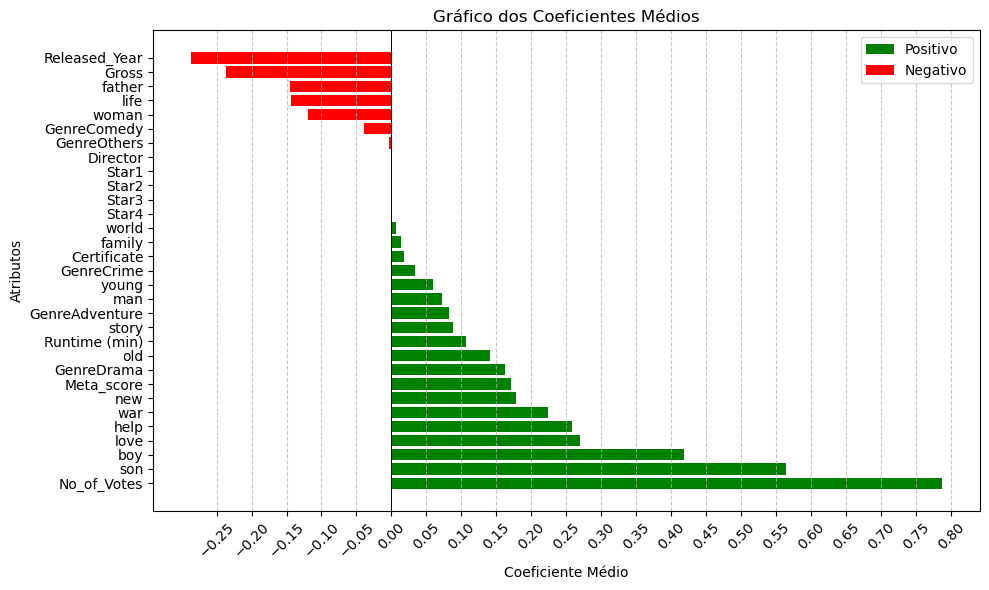

In [204]:
# Plotando um gráfico para comparação dos coeficientes médios de cada atributo
coef_pos = df_importances[df_importances['Média dos Coeficientes']>=0]['Média dos Coeficientes']
coef_neg = df_importances[df_importances['Média dos Coeficientes']<0]['Média dos Coeficientes']
plt.figure(figsize=(10, 6))
coef_graf_pos = plt.barh(coef_pos.index, coef_pos, color='g')
coef_graf_neg = plt.barh(coef_neg.index, coef_neg, color='r')
plt.xlabel('Coeficiente Médio')
plt.ylabel('Atributos')
plt.title('Gráfico dos Coeficientes Médios')
plt.xticks([i/20 for i in range(-5, 17)], rotation=45)
plt.legend(['Positivo', 'Negativo'], loc='upper right')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.axvline(0, color='black', linewidth=0.7)
plt.tight_layout()
plt.savefig('../resultados/GráficoCoeficientesMédios.png')
plt.show()

## Novas Predições

In [205]:
# Definindo um novo dataframe contendo as características do novos filmes
df_novo_filme = pd.DataFrame({'Series_Title': ['The Shawshank Redemption'],
     'Released_Year': ['1994'],
     'Certificate': ['A'],
     'Runtime': ['142 min'],
     'Genre': ['Drama'],
     'Overview': ['Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.'],
     'Meta_score': [80.0],
     'Director': ['Frank Darabont'],
     'Star1': ['Tim Robbins'],
     'Star2': ['Morgan Freeman'],
     'Star3': ['Bob Gunton'],
     'Star4': ['William Sadler'],
     'No_of_Votes': [2343110],
     'Gross': ['28,341,469']})
df_novo_filme.to_excel('../resultados/NovosDados.xlsx', index=False)
df_novo_filme

,Series_Title,Released_Year,Certificate,Runtime,Genre,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,The Shawshank Redemption,1994,A,142 min,Drama,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"


### Tratamento das novas predições

In [122]:
# Criando uma função para executar simplificadamente o tratamento dos dados necessário para predição
def tratar_novos_dados(df):
    df['Runtime (min)'] = df['Runtime'].str.replace(" min", "").astype("int64")
    df.drop(columns="Runtime", inplace=True)
    df['Released_Year'] = df['Released_Year'].astype('int64')
    df.dropna()
    df['Gross'] = df['Gross'].str.replace(',', '').astype('int64')
    df['Genre'] = df['Genre'].str.split(", ")
    
    generos(df)
    
    tfidf_novo_overview = tfidf.transform(df['Overview'])
    df = pd.concat([df,pd.DataFrame(tfidf_novo_overview.toarray(), columns=tfidf.get_feature_names_out(), index=df.index)], axis=1)
    df.drop(columns='Overview', inplace=True)
    
    titulo = df['Series_Title']
    X = df.drop(columns='Series_Title')
    
    X['Director'] = le_director.transform(X['Director'])
    
    df_nova_stars = pd.concat([df['Star1'], df['Star2'], df['Star3'], df['Star4']], axis=0).reset_index(drop=True)
    stars = le_stars.fit_transform(df_nova_stars)
    for column in columns_stars:
        X[column] = le_stars.transform(X[column])
        
    X['Certificate'] = le_certificate.transform(X['Certificate'])
    
    X[quant_scal] = scaler.transform(X[quant_scal])
    return titulo, X

In [123]:
titulo_novo, X_novo = tratar_novos_dados(df_novo_filme)
X_novo

,Released_Year,Certificate,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,...,love,man,new,old,son,story,war,woman,world,young
0,-0.093491,0,0.229303,103,2,1,0,3,5.746981,-0.435774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:
y_novo_pred = (stacking_reg.predict(X_novo)).reshape(-1,1)
y_novo_pred_inv = (scaler_y.inverse_transform(y_novo_pred)).ravel()
y_novo_pred_inv

array([8.80617065])

In [131]:
novas_pred = pd.DataFrame({'Título': titulo_novo,
                           'Nota Prevista': y_novo_pred_inv})
novas_pred

,Título,Nota Prevista
0,The Shawshank Redemption,8.806171
